In [2]:
import copy
import os
import json
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, utils, datasets
from torchvision.models import mobilenet_v3_large
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/pbag/miniconda3/envs/lego-env/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Download Data

In [8]:
# if not 'KAGGLE_KEY' in os.environ:
#     os.environ['KAGGLE_KEY'] = input()

In [10]:
# !mkdir .kaggle
# !touch .kaggle/kaggle.json

# api_token = {"username":"porter7678","key":os.environ['KAGGLE_KEY']}

# with open('.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 .kaggle/kaggle.json

In [12]:
# !kaggle datasets download -d pacogarciam3/lego-brick-sorting-image-recognition
# !mkdir lego_data
# !unzip -q lego-brick-sorting-image-recognition.zip -d lego_data

Dataset URL: https://www.kaggle.com/datasets/pacogarciam3/lego-brick-sorting-image-recognition
License(s): CC-BY-SA-3.0
100%|████████████████████████████████████████| 616M/616M [03:01<00:00, 3.94MB/s]
100%|████████████████████████████████████████| 616M/616M [03:01<00:00, 3.56MB/s]
mkdir: cannot create directory ‘lego_data’: File exists


In [ ]:
# Remove all the files I'm not using
# !rm lego-brick-sorting-image-recognition.zip
# !rm -r lego_data/Base\ Images
# !rm -r lego_data/base\ images
# !rm -r lego_data/cropped\ images
# !rm lego_data/Image_Count_Summary.jpg
# !rm lego_data/background_backlit_A.jpg
# !rm lego_data/background_backlit_B.jpg
# !rm lego_data/example_1_Cropped\ Image.jpg
# !rm lego_data/example_2_Base\ Image.jpg
# !rm lego_data/ImageSetKey.csv
# !mv lego_data/Cropped\ Images lego_data/cropped_images
# !rm -r lego_data/cropped_images/P*
# !rm lego_data/cropped_images//Brick_1x1/1_Brick_1x1_180708133346.jpg # These images aren't cropped
# !rm lego_data/cropped_images//Brick_1x1/1_Brick_1x1_180708133400.jpg

## Build Dataset

In [13]:
class RescalePadToTensor(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, img):
        img = img.transpose((2, 0, 1))
        img = torch.Tensor(img.copy())
        C, H, W = img.shape

        # Resize and pad to minimize distortion, maintaining aspect ratio
        if H == W:
            new_img = transforms.Resize((self.output_size, self.output_size))(img)
        elif H > W:
            prop = W/H
            new_W = int(self.output_size*prop)
            new_img = transforms.Resize((self.output_size, new_W))(img)

            is_odd = (self.output_size - new_W)%2
            pad_size = (self.output_size - new_W)//2
            new_img = transforms.Pad([pad_size, 0, pad_size+is_odd, 0], padding_mode='edge')(new_img)
        else:
            prop = H/W
            new_H = int(self.output_size*prop)
            new_img = transforms.Resize((new_H, self.output_size))(img)

            is_odd = (self.output_size - new_H)%2
            pad_size = (self.output_size - new_H)//2
            new_img = transforms.Pad([0, pad_size, 0, pad_size+is_odd], padding_mode='edge')(new_img)
        return new_img

In [23]:
class LegoDataset(Dataset):

    def __init__(self, split, transform=None, root_dir='lego_data/base_images', seed=42):
        """
        Args:
         - split (str): train, val, or test split
        """
        self.root_dir = root_dir
        self.image_folder = datasets.ImageFolder(root=self.root_dir) # imgs is the attribute where everything lives
        self.class_names = self.image_folder.classes

        # Train/Val/Test - 70/10/20
        X, y = map(list, zip(*self.image_folder.imgs))

        if split is None:
            self.imgs, self.labels = (X, y)
        else:
            _X, X_test, _y, y_test = train_test_split(X, y, test_size=.2, random_state=seed)
            X_train, X_val, y_train, y_val = train_test_split(_X, _y, test_size=.125, random_state=seed)

            splits = {'train': (X_train, y_train),
                        'val':(X_val, y_val),
                        'test': (X_test, y_test)}
            
            if split not in splits:
                raise ValueError('Invalid split name')
            self.imgs, self.labels = splits[split]
            
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.imgs[idx]
        image = plt.imread(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
def show_torch_img(img):
    plt.imshow(img.long().numpy().transpose(1, 2, 0))

In [16]:
input_img_size = 224
batch_size = 32

# Resize, pad, rotate, translate, scale, blur, flip
train_transforms = transforms.Compose([
    RescalePadToTensor(input_img_size),
    # transforms.RandomAffine(degrees=(0, 10)), # translate=(0, .3), scale=(0.75, 1)),
    # transforms.GaussianBlur(kernel_size=5),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
])

train_dataset = LegoDataset('train', transform=train_transforms)
val_dataset = LegoDataset('val', transform=RescalePadToTensor(input_img_size))
test_dataset = LegoDataset('test', transform=RescalePadToTensor(input_img_size))

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_dl,
               'val': val_dl,
               'test': test_dl}
dataset_sizes = {'train': len(train_dataset),
                'val': len(val_dataset),
                'test': len(test_dataset)}
class_names = train_dataset.class_names

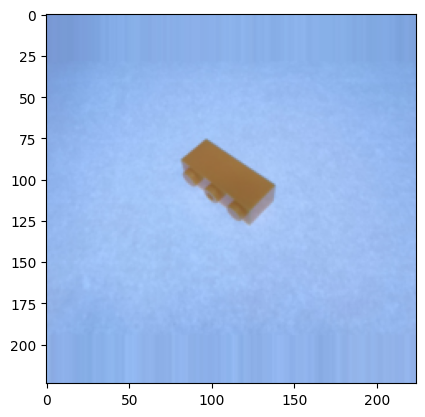

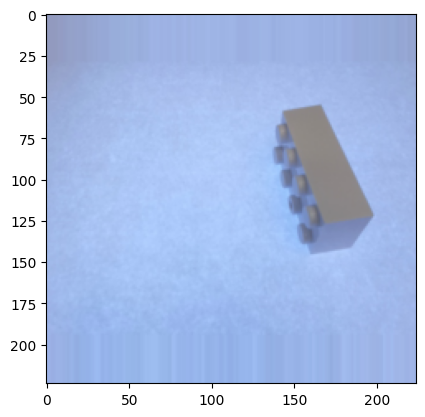

In [17]:
for (x, y_truth) in train_dl:
    show_torch_img(x[0])
    plt.show()
    show_torch_img(x[1])
    plt.show()
    break

# Model

In [18]:
mobilenet = mobilenet_v3_large(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /home/pbag/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:06<00:00, 3.28MB/s]


In [19]:
for param in mobilenet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
in_ftrs = mobilenet.classifier[3].in_features
out_ftrs = len(train_dataset.class_names)
mobilenet.classifier[3] = nn.Linear(in_ftrs, out_ftrs)
mobilenet = mobilenet.to(device)
mobilenet_optimizer = optim.SGD(mobilenet.classifier[3].parameters(), lr=0.001, momentum=0.9)

# Training

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loop = tqdm(total=num_epochs, position=0, leave=False)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = np.inf
    train_acc = np.inf
    val_loss = np.inf
    val_acc = np.inf
    all_train_losses = []
    all_train_acc = []
    all_val_losses = []
    all_val_acc = []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
                all_train_losses.append(train_loss)
                all_train_acc.append(train_acc)
                loop.set_description(f'epoch:{epoch}, loss:{train_loss:.4f}, acc:{train_acc:.3f}, val_loss:{val_loss:.4f}, val_acc:{val_acc:.3f}')
                loop.update(1)
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc.item()
                all_val_losses.append(val_loss)
                all_val_acc.append(val_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, all_train_losses, all_train_acc, all_val_losses, all_val_acc

In [21]:
def visualize_model(model, num_images=6, figsize=(10, 8)):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for (inputs, labels) in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('pred: {}\nactual: {}'.format(class_names[preds[i]], class_names[labels[i]]))
                show_torch_img(inputs.cpu().data[i])

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.gcf().set_size_inches(*figsize)
                    plt.show()
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
torch.manual_seed(42)

model = mobilenet
optimizer = mobilenet_optimizer
criterion = nn.CrossEntropyLoss(reduction='sum')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

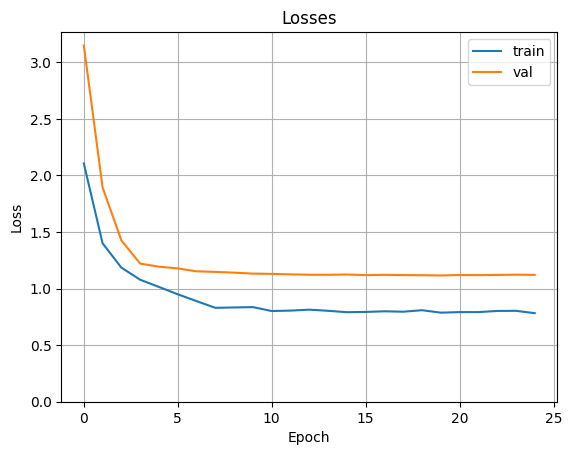

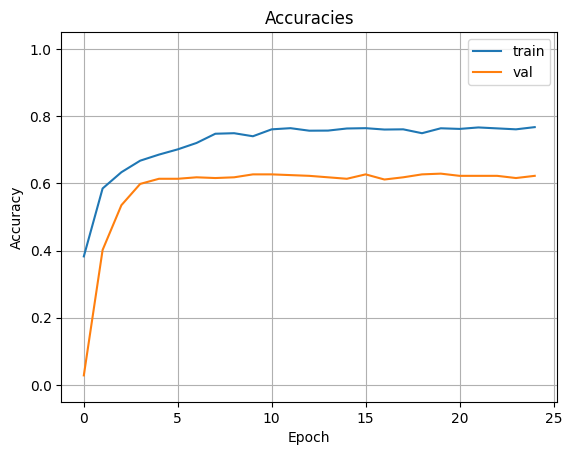

0.62882096069869


In [24]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim(bottom=0)
plt.title('Losses')
plt.legend()
plt.show()

train_accs = [t.item() for t in train_accs]
plt.plot(np.arange(num_epochs), train_accs, label='train')
plt.plot(np.arange(num_epochs), val_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(-0.05, 1.05)
plt.title('Accuracies')
plt.legend()
plt.show()

print(max(val_accs))

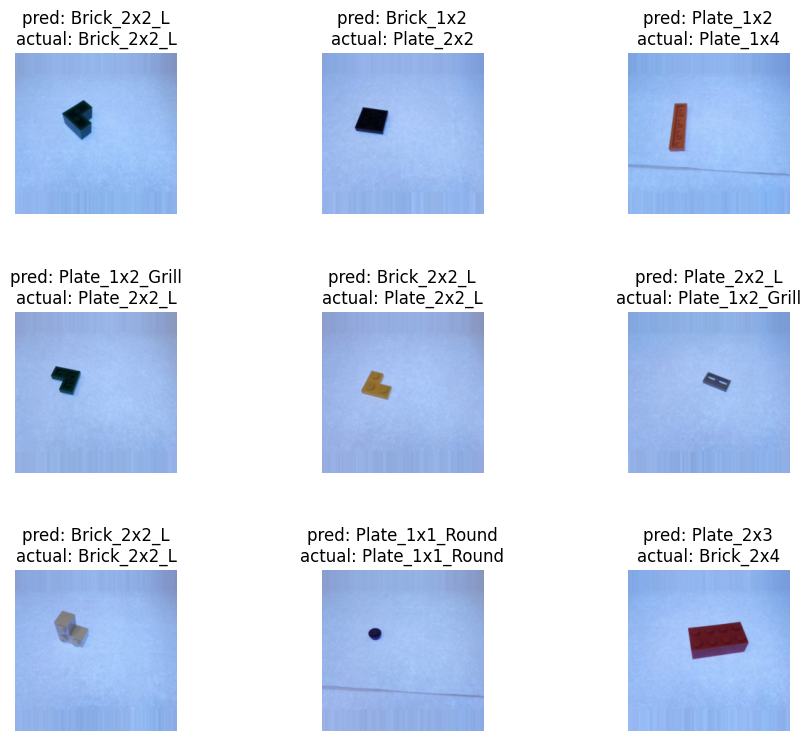

In [26]:
visualize_model(model, num_images=9)

### Validation Results
 - Accuracy with MobileNet, size 64, no data augmentation: 0.5797
 - Accuracy with MobileNet, size 128, no data augmentation: 0.7391
 - Accuracy with ResNet, size 128, no data augmentation: 0.7826
 - Accuracy with MobileNet, size 128, lots of data augmentation: 0.4589
 - Accuracy with MobileNet, size 128, little data augmentation: 0.7198
 - **Accuracy with MobileNet, size 128, only flip: 0.8357**
 - Accuracy with MobileNet, size 128, flip and blur: 0.7391
 - Accuracy with MobileNet, size 128, two flips: 0.8019
  - **Accuracy with MobileNet, size 224, horz flip: 0.8744**

## Test Results

In [25]:
running_corrects = 0
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects / dataset_sizes['test']
test_acc = test_acc.item()
print('Accuracy on test set:', np.round(test_acc, 4))

Accuracy on test set: 0.6288


## Save Model

In [28]:
to_save = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": train_losses[-1]
}
model_save_path = "./checkpoints/kaggle_only.tar"
torch.save(to_save, model_save_path)

## Inference on My Images

In [29]:
input_img_size = 224
porter_transforms = transforms.Compose([
    RescalePadToTensor(input_img_size),
    transforms.RandomVerticalFlip(1.0), # All images are upside down
])
porter_dataset = LegoDataset(split=None, transform=porter_transforms, root_dir="porter_data")
porter_dl = DataLoader(porter_dataset, batch_size=32, shuffle=False)

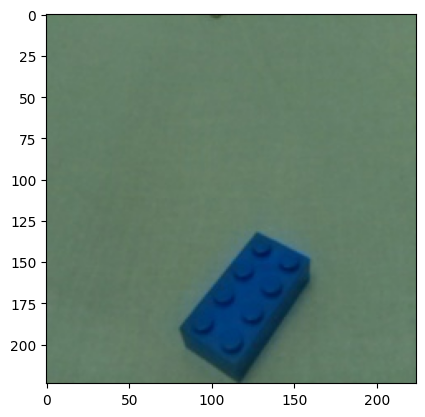

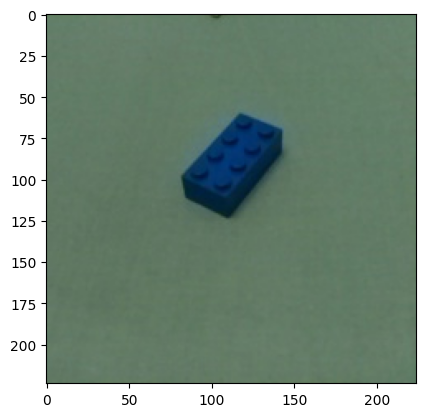

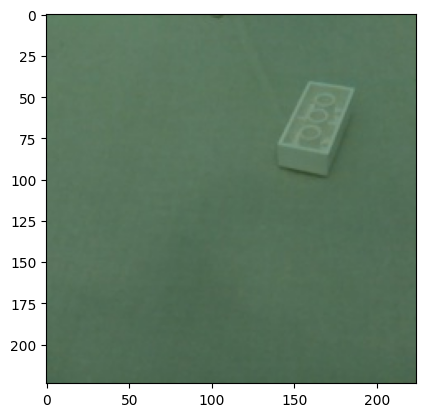

In [30]:
for (x, y_truth) in porter_dl:
    show_torch_img(x[0])
    plt.show()
    show_torch_img(x[1])
    plt.show()
    show_torch_img(x[-1])
    plt.show()
    break

pred: Brick_2x4


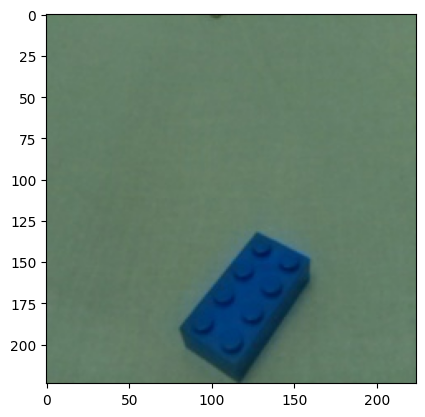

pred: Brick_2x4


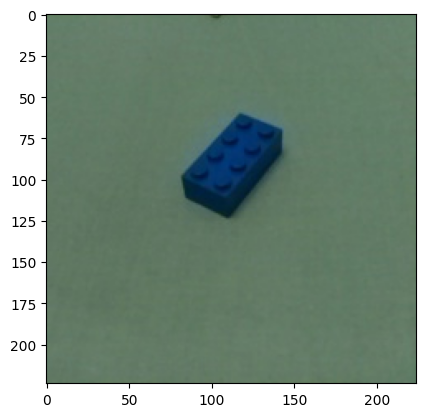

pred: Brick_2x4


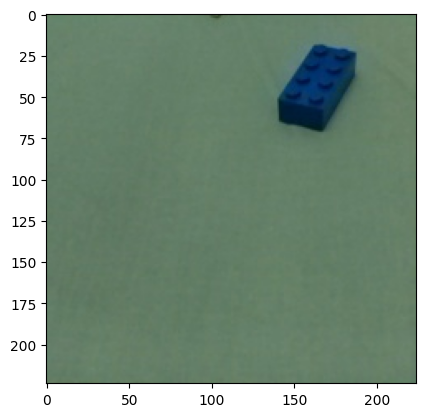

pred: Brick_2x4


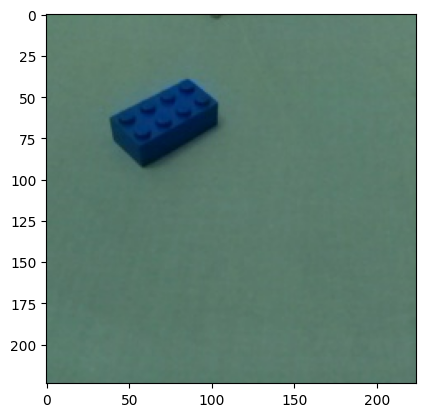

pred: Brick_2x4


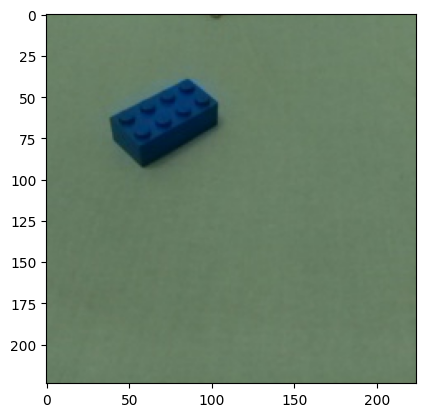

pred: Plate_1x4


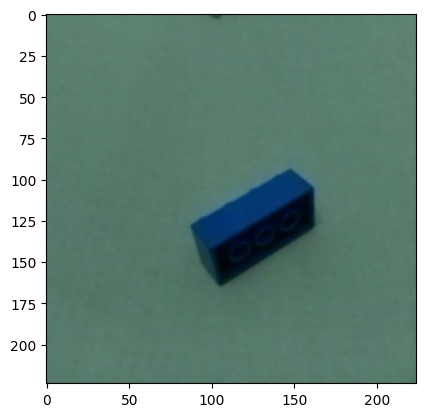

pred: Plate_1x4


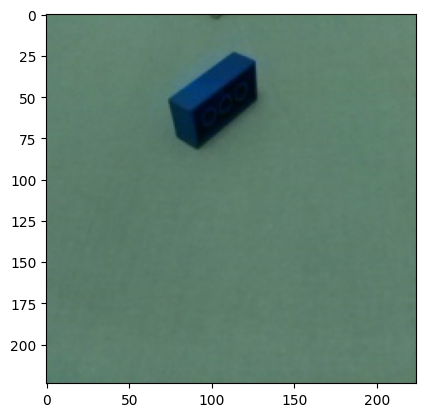

pred: Brick_1x4


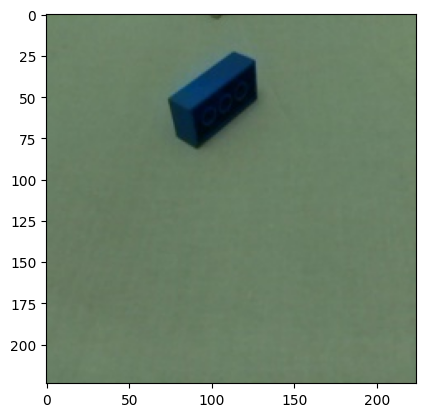

pred: Brick_2x2_L


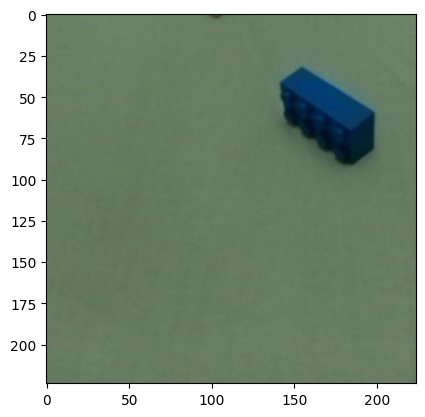

pred: Brick_2x4


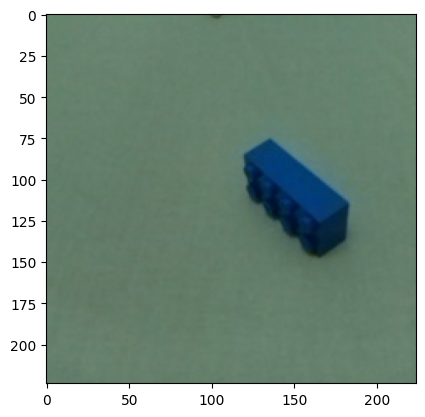

pred: Plate_1x4


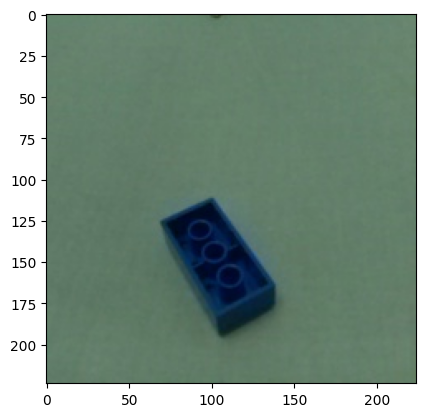

pred: Plate_1x4


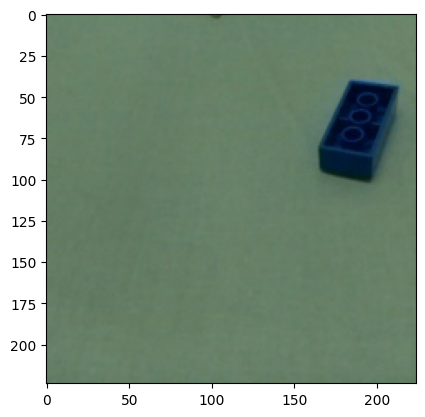

pred: Brick_2x4


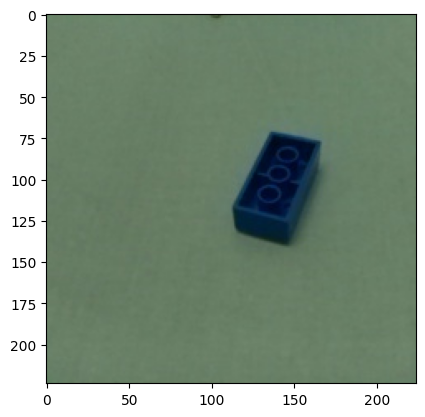

pred: Plate_1x1


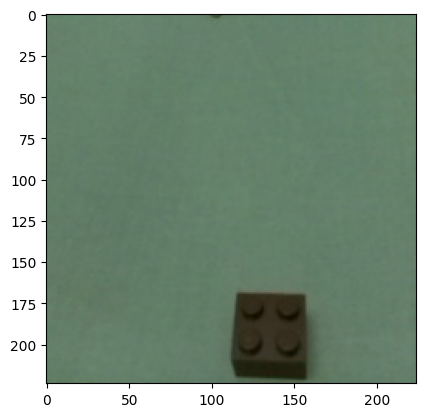

pred: Brick_2x4


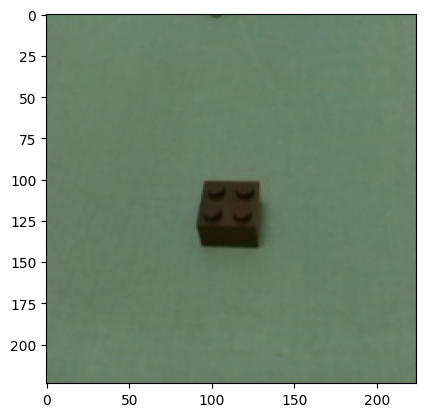

pred: Plate_1x4


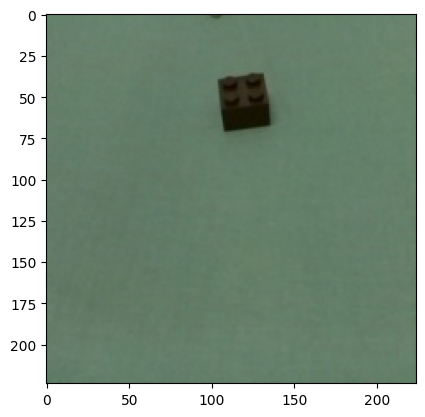

pred: Brick_2x4


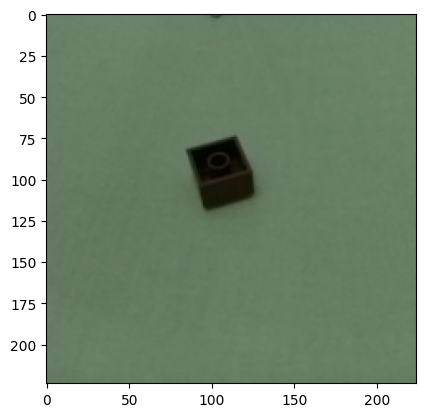

pred: Brick_2x4


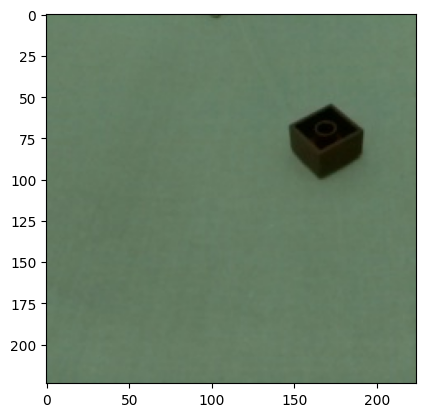

pred: Brick_2x4


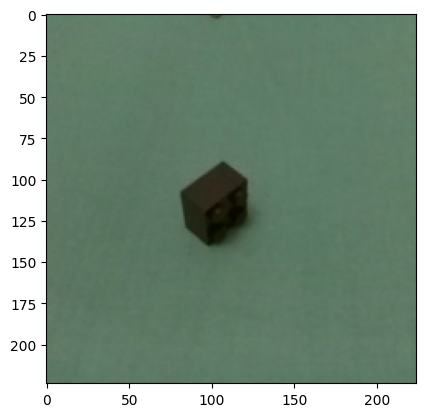

pred: Brick_2x4


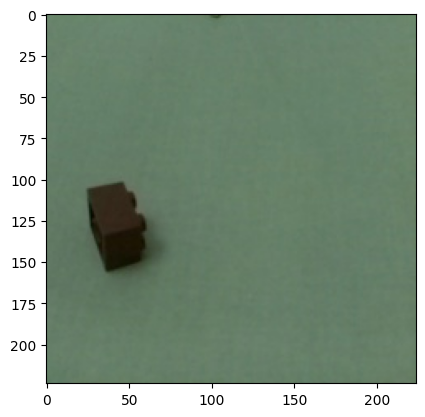

pred: Plate_1x1


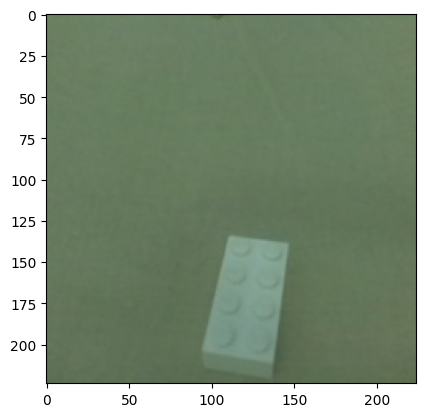

pred: Brick_2x4


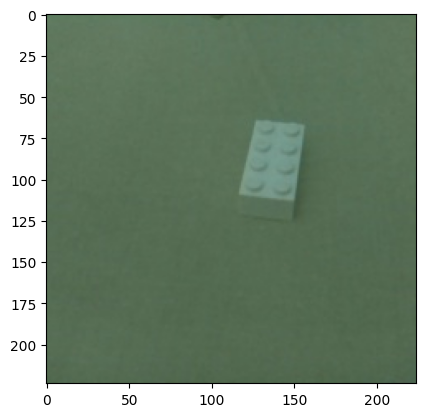

pred: Plate_1x1


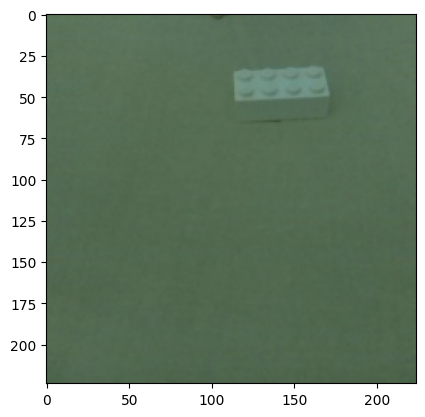

pred: Brick_2x4


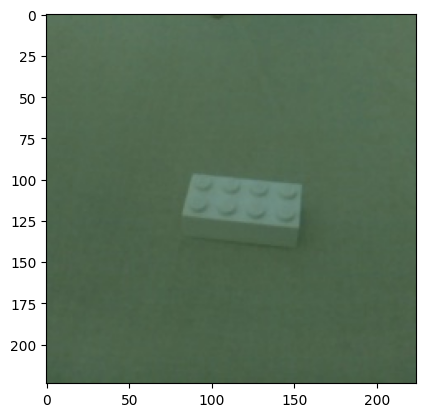

pred: Brick_2x4


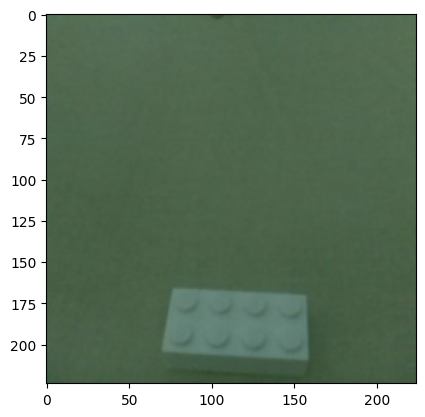

pred: Brick_2x2_L


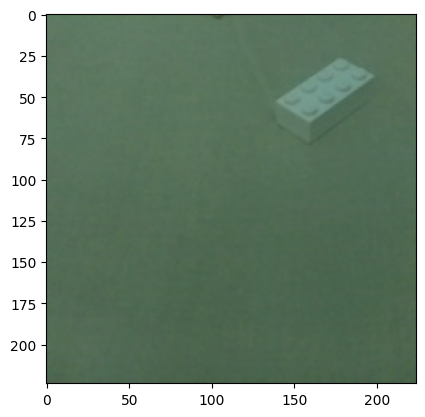

pred: Plate_1x4


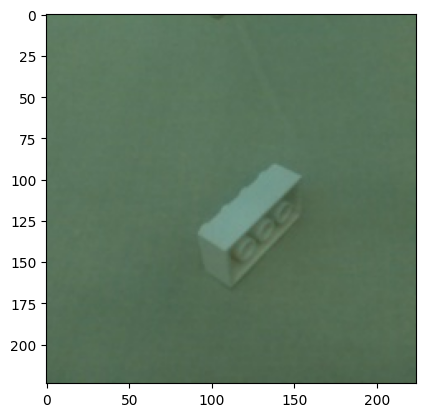

pred: Brick_2x4


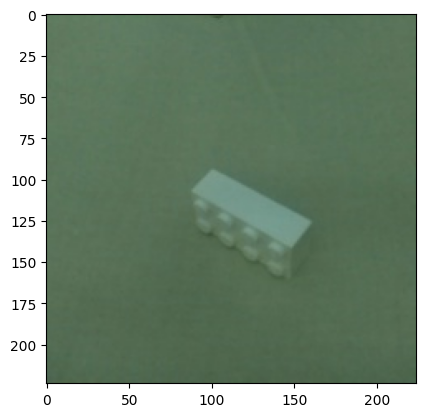

pred: Brick_2x2_L


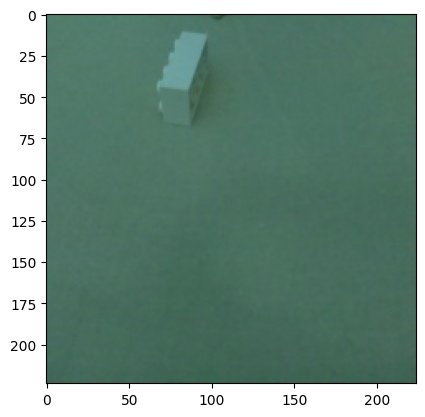

pred: Plate_1x4


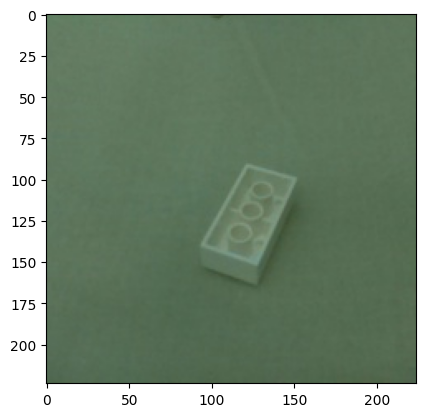

pred: Brick_2x4


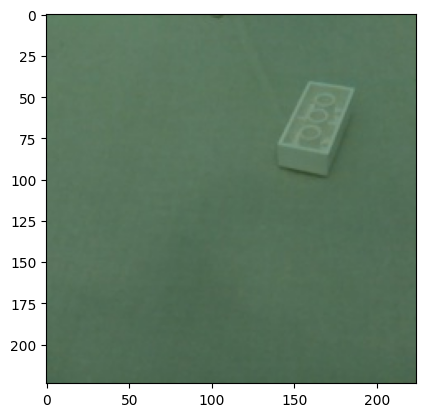

In [32]:
model.eval()

with torch.no_grad():
    for (inputs, labels) in porter_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size()[0]):
            print(f"pred: {class_names[preds[i]]}")
            show_torch_img(inputs.cpu().data[i])
            plt.show()